In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment
from util.random import smooth_random_loop_fourier_coef

## Domain
Start by defining the domain. A channel flow with random inclusions.

### Notes
* ``on_boundary`` breaks process of extracting rough boundary, since edges in the ``BoundaryMesh`` are not on its boundary.
* ``ds(mesh_func)``  must be with respect to a mesh function of dimension 1.
* ``alpha`` is computed with the normal derivative of the OUTWARDS facing normal ``n``.


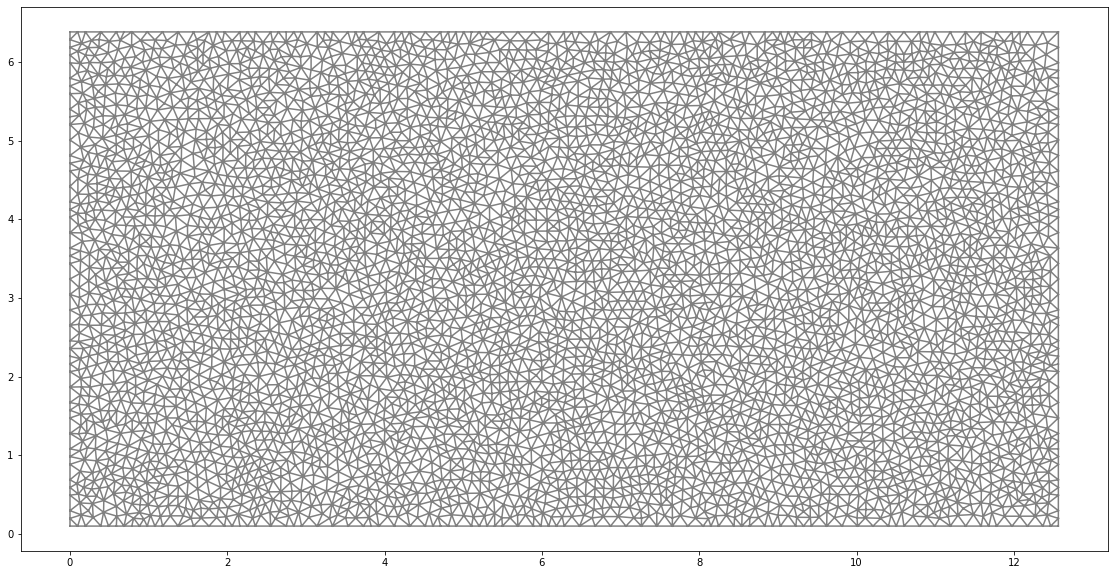

In [11]:
#### True solution
psi = lambda x, y: np.sin(x)*np.sin(y) # Stream function
u = lambda x, y: np.sin(x)*np.cos(y) # Velocity
v = lambda x, y: -np.cos(x)*np.sin(y) # Velocity
p = lambda x, y: 2 * psi(x, y) # Pressure
alfa = lambda x, y: np.cos(y) / np.sin(y) # Robin parameter

#### DOMAIN
box = [[0, 4*np.pi], [0.1, np.pi*2+0.1]]
domain = ms.Rectangle(dl.Point(box[0][0], box[1][0]), dl.Point(box[0][1], box[1][1]))
res = 64
mesh = ms.generate_mesh(domain, resolution=res)


### FLOOR
class Floor(dl.SubDomain):
    def __init__(self, dim=1):
        self.dim = dim
        super().__init__()
        
    def inside(self, x, on_boundary):
        if self.dim==2:
            return bool(x[1] < box[1][0] + dl.DOLFIN_EPS and on_boundary)
        else:
            return bool(x[1] < box[1][0] + dl.DOLFIN_EPS)# and not dl.near(x[0], box[0][0]))# and not dl.near(x[0], box[0][1]))
            #return False

#### OTHER BOUNDARIES
class Walls(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and \
               (dl.near(x[0], box[0][0]) or \
                dl.near(x[0], box[0][1]) or \
                dl.near(x[1], box[1][1]))# or dl.near(x[1], box[1][0]))

walls = Walls()
floor = Floor(dim=1)

plt.figure(figsize=(20,10))
dl.plot(mesh)

In [12]:
# Define the function spaces
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1)
U, P = W.split() 
Ux, Uy = U.split()

# Boundary Conditions
bcu = dl.DirichletBC(U, dl.Expression((f'sin(x[0])*cos(x[1])', f'-cos(x[0]) * sin(x[1])'), degree=2), walls)

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.
Solving linear variational problem.


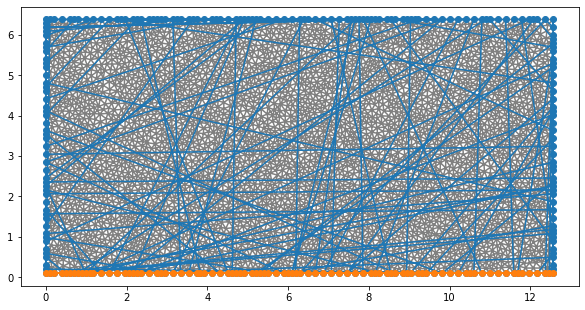

In [13]:

#data = StokesData.from_mesh(mesh, floor, None, W, bcu)
data = StokesData(mesh, None, None, None, Floor(), None, W, bcu)
plt.figure(figsize=(10,10))

bm = dl.BoundaryMesh(data.macro_mesh, 'exterior')
dl.plot(bm)
dl.plot(dl.SubMesh(bm, floor))
dl.plot(data.macro_mesh)

def interp(x, a):
    amean = np.mean(a)
    return lambda x, y: amean #basis(np.array([x]))[0]

mac = StokesMacProb(data, interp=interp, \
                    alpha0=lambda x,y:  -np.cos(y)/np.sin(y), \
                    g=lambda x, y: -1.*v(x, y), \
                    f = dl.Expression((f'2*sin(x[0])*cos(x[1])', f'-2*cos(x[0]) * sin(x[1])'), degree=2),\
                    lam=0.*res)#1e-10)

mac_solver = MacroSolver()

sol = mac_solver.solve(mac, verbose=True)

Object cannot be plotted directly, projecting to piecewise linears.


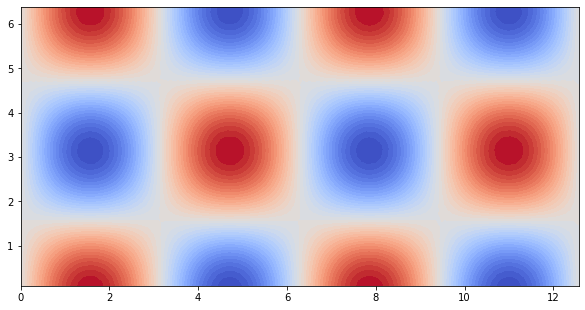

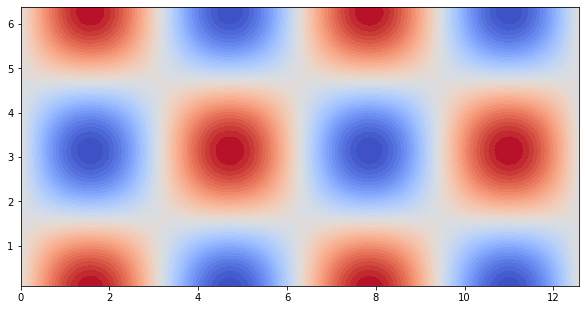

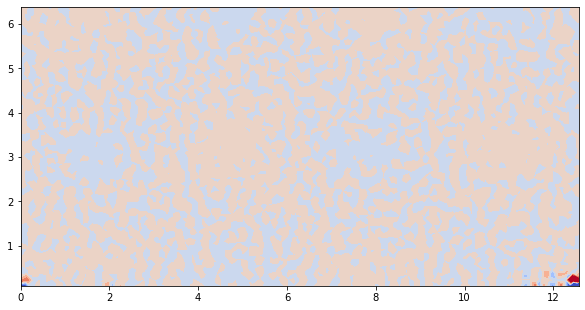

In [33]:
u_norm = (sol.u * sol.u + sol.v * sol.v) ** 0.5



axis = 0
S = U.sub(axis).collapse()
f_true = dl.Function(S)
if axis==0:
    f_true.vector()[:] = np.array([u(x[0], x[1]) for x in S.tabulate_dof_coordinates()])
    f = dl.project(sol.u, S)
else:
    f_true.vector()[:] = np.array([v(x[0], x[1]) for x in S.tabulate_dof_coordinates()])
    f = dl.project(sol.v, S)

plt.figure(figsize=(10,10))
dl.plot(f, cmap='coolwarm', vmin=-1., vmax=1.)


plt.figure(figsize=(10,10))
dl.plot(f_true, vmin=-1., vmax=1., cmap='coolwarm')
#dl.plot(dl.)


delta = f_true - f
ran = 1e-4
plt.figure(figsize=(10,10))
dl.plot(delta, cmap='coolwarm', vmin=-ran, vmax=ran)